# Vegas Notebook for WIC MC Generation

In [1]:
import numpy as np
from numpy import genfromtxt
from numpy import random
import matplotlib as mpl
import matplotlib.gridspec
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import scipy as sp
from scipy.integrate import quad, dblquad, tplquad, simpson
from scipy import interpolate
from parton import mkPDF
import vegas
import pandas as pd
from functools import partial 

## My imports
import WIC_Pheno_Formulae as WIC
from WIC_Pheno_Formulae import *
import PlottingModules as PM
import VegasMC_Generation as VMC
from VegasMC_Generation import *
import ConvertToLHE

## Import Spectral Densities  (w/ correct normalization!)

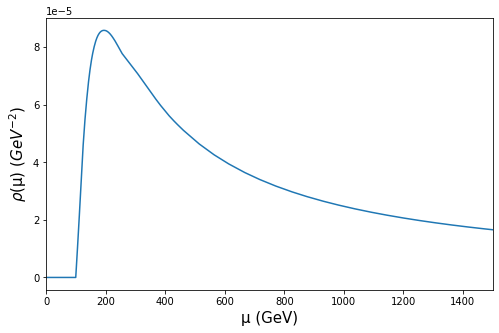

In [2]:
μs = np.linspace(0,15000,15001)

## With k = 10^17 GeV 
mySD100R30ex = genfromtxt('mySD100R30ex.csv', delimiter=',')
mySD100R50ex = genfromtxt('mySD100R50ex.csv', delimiter=',')
mySD100R80ex = genfromtxt('mySD100R80ex.csv', delimiter=',')
mySD100R200ex = genfromtxt('mySD100R200ex.csv', delimiter=',')
mySD100R1000ex = genfromtxt('mySD100R1000ex.csv', delimiter=',')

## With k = 10^10 GeV 
ϼ100R30_k1010CSV = genfromtxt('SD100R30_k1010.csv', delimiter=',')
ϼ100R80_k1010CSV = genfromtxt('SD100R80_k1010.csv', delimiter=',')
μs1, ϼ100R30_k1010 = ϼ100R30_k1010CSV[:,0], ϼ100R30_k1010CSV[:,1]
μs2, ϼ100R80_k1010 = ϼ100R80_k1010CSV[:,0], ϼ100R80_k1010CSV[:,1]

## Multiply by μ
μmySD100R30ex = mySD100R30ex*μs; 
μmySD100R50ex = mySD100R50ex*μs; 
μmySD100R80ex = mySD100R80ex*μs; 
μmySD100R200ex = mySD100R200ex*μs; 
μmySD100R1000ex = mySD100R1000ex*μs

μϼ100R30_k1010 = ϼ100R30_k1010*μs1
μϼ100R80_k1010 = ϼ100R80_k1010*μs2

## Interpolate
μϼ100R30 = interpolate.interp1d(μs, μmySD100R30ex)
μϼ100R50 = interpolate.interp1d(μs, μmySD100R50ex)
μϼ100R80 = interpolate.interp1d(μs, μmySD100R80ex)
μϼ100R200 = interpolate.interp1d(μs, μmySD100R200ex)
μϼ100R1000 = interpolate.interp1d(μs, μmySD100R1000ex)

ϼ100R30_k1010 = interpolate.interp1d(μs1, ϼ100R30_k1010)
ϼ100R80_k1010 = interpolate.interp1d(μs2, ϼ100R80_k1010)

μϼ100R30_k1010 = interpolate.interp1d(μs1, μϼ100R30_k1010)
μϼ100R80_k1010 = interpolate.interp1d(μs2, μϼ100R80_k1010)


fig, ax = plt.subplots(1, 1, figsize = (8,5));
μs = np.linspace(0,15000,15001)
μsNEW = np.linspace(1,2499,2499)
# ax.scatter(μs, μϼ100R30(μs)/μs, s=1, alpha=0.1)
# ax.scatter(μs, μϼ100R80(μs)/μs, s=1, alpha=0.1)
# ax.scatter(μsNEW, ϼ100R30_k1010(μsNEW), s=1, alpha=0.5)
# ax.scatter(μsNEW, ϼ100R80_k1010(μsNEW), s=1, alpha=0.5)
ax.plot(μsNEW, ϼ100R80_k1010(μsNEW))
ax.set_xlim(0,1500)
ax.set_xlabel('μ (GeV)', size=15)
ax.set_ylabel(r'$\rho$(μ) ($GeV^{-2}$)', size=15)
plt.savefig('Paper/Plots/SpectralDensity_k1010_R30.png')

# Cross Section σ

In [3]:
## Training & Unweighting for Production Cross Section  # 500,000 takes ~ 30 min
dσ_dμdμp_sqrtS_500_dict = VMC.run_MC_dσ_dμdμp(NPoints=5000, sqrtS=500, μ0=100, μϼ=μϼ100R80_k1010) 
dσ_dcosθ_dict = VMC.run_MC_dσ_dcosθ(NPoints=5000)

Running dσ/dμdμp MC for √s = 500 ... 
(4841,) (4841,)
0 of 625
shape of raw hist = (4841,)
shape of rescaled hist = (532,)
Unweighting Efficiency(?) = 0.10989464986573022
Returning μ1, μ1p Events, Integral
Running dσ/dcosθ MC ... 
(4709,)
0 of 625
(4709,)
(823,)
Returning cosθ Events, Integral


In [4]:
# Number of Events & Integrals
print(np.shape(dσ_dμdμp_sqrtS_500_dict["μ1 Events"]))
print(np.shape(dσ_dμdμp_sqrtS_500_dict["μ1p Events"]))
print(np.shape(dσ_dcosθ_dict["cosθ Events"]))
print(dσ_dμdμp_sqrtS_500_dict['Integral'])
print(dσ_dcosθ_dict["Integral"])
## Total Cross Section
print('σ = ' + str(dσ_dμdμp_sqrtS_500_dict['Integral']*dσ_dcosθ_dict["Integral"]))

(532,)
(532,)
(823,)
50.53734259906572
1.3332650797809815
σ = 67.37967411226215


(532,)
50.53734259906572
1.3332650797809815
67.37967411226215


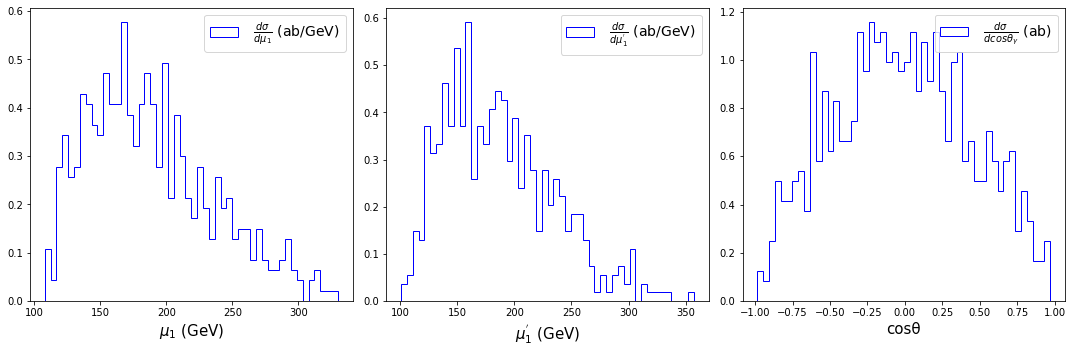

In [5]:
## Plots from PM
ProductionPlot = PM.Plotter('dσ_dμdμpdcosθ', [2,1], (15,5), 50)
print(np.shape(dσ_dμdμp_sqrtS_500_dict['μ1p Events']))
ProductionPlot.addPlot([dσ_dμdμp_sqrtS_500_dict, dσ_dcosθ_dict], [['blue','blue'],['blue']], 'linear')
ProductionPlot.addFeatures([dσ_dμdμp_sqrtS_500_dict, dσ_dcosθ_dict], 
                           [r'$μ_{1}$ (GeV)',r"$μ_{1}^{'}$ (GeV)",r'cosθ'],
                      legend=True, legendlabel=[[r'$\,\,\frac{dσ}{dμ_{1}}$ (ab/GeV)'],
                                              [r"$\,\,\frac{dσ}{dμ_{1}^{'}}$ (ab/GeV)"],
                                              [r"$\,\,\frac{dσ}{dcosθ_{γ}}$ (ab)"]])
print(dσ_dμdμp_sqrtS_500_dict['Integral'])
print(dσ_dcosθ_dict['Integral'])
print(dσ_dμdμp_sqrtS_500_dict['Integral']*dσ_dcosθ_dict['Integral'])
plt.tight_layout()
plt.savefig('Paper/Plots/VegasProjections_WIC_eeProduction.png')

# Cross Section σ (with ISR) 

In [6]:
## Training & Unweighting for Production Cross Section ISR 
dσ_deγdcosθγdμ1dμ1p_sqrtS_500_dict = VMC.run_MC_dσ_deγdcosθγdμdμp(NPoints=10000, 
                                                                 sqrtS=500, μ0=100, μϼ=μϼ100R80_k1010)

Running dσ/deγdcosθγdμdμp MC for √s = 500 ... 
(9470,) (9470,) (9470,) (9470,)
0 of 1080
(9470,)
(1117,)
Returning μ1, μ1p Events, eγ Events, cosθγ Events, Integral


In [7]:
# Number of Events & Integral 
print(np.shape(dσ_deγdcosθγdμ1dμ1p_sqrtS_500_dict["μ1 Events"]))
# Cross Section 
print('σISR = ' + str(dσ_deγdcosθγdμ1dμ1p_sqrtS_500_dict['Integral']))

(1117,)
σISR = 429.8463184048928


429.8463184048928


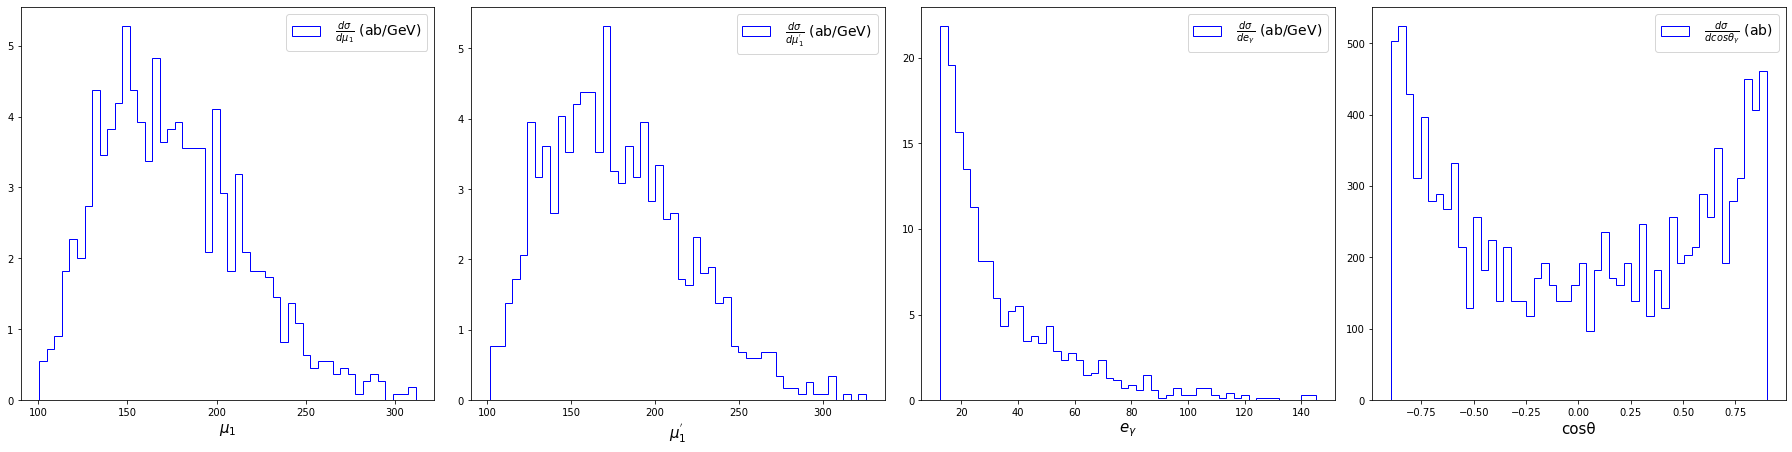

In [8]:
## Plotting with class
ProductionPlot = PM.Plotter('dσ_deγdcosθγdμ1dμ1p', [4], (25,6), 50)
ProductionPlot.addPlot([dσ_deγdcosθγdμ1dμ1p_sqrtS_500_dict], [['blue','blue','blue','blue']], 'linear')
ProductionPlot.addFeatures([dσ_deγdcosθγdμ1dμ1p_sqrtS_500_dict], [r'$μ_{1}$',r"$μ_{1}^{'}$",r'$e_{γ}$',r'cosθ'],
                      legend=True, legendlabel=[[r'$\,\,\frac{dσ}{dμ_{1}}$ (ab/GeV)'],
                                        [r"$\,\,\frac{dσ}{dμ_{1}^{'}}$ (ab/GeV)"],
                                        [r'$\,\,\frac{dσ}{de_{γ}}$ (ab/GeV)'],
                                        [r"$\,\,\frac{dσ}{dcosθ_{γ}}$ (ab)"]])
print(dσ_deγdcosθγdμ1dμ1p_sqrtS_500_dict['Integral'])

# Rate Γ

### 3-body Decay MC

In [ ]:
## Mass Spectrum from Mathematica
MassSpec = np.array([102.442,104.436,106.861,110.122,114.169,118.899,124.205,129.994,136.182,142.706,
                         149.52,156.593,163.899,171.411,179.103,186.95,194.932,203.039,211.261,219.591,
                         228.018,236.534,245.128,253.793,262.525,271.319,280.171,289.076,298.029,307.026,
                         316.062,325.135,334.242,343.381,352.551,361.748,370.971,380.217,389.483,398.77])
print(VMC.Δm(200, MassSpec)*2*200)
print(VMC.Δm2(200, MassSpec))

In [ ]:
 ## Running MC for dΓ3/dμ2dx3dx4 for different μ1 ## 
NPoints = 500  ## 100,000 takes ~1 hour
masses = [101, 101.5, 102, 103, 104, 105, 110, 120, 130, 140, 150, 160, 170, 180, 190, 
          195, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 
          340, 350, 360, 370, 380, 390]
# masses = [101, 101.5, 102]
d3Γ3_ds = []
for i, m in enumerate(masses):
    d3Γ3_ds.append(m)
    d3Γ3_ds.append(VMC.run_MC_dΓ3_dμ2(NPoints, m, 100, μϼ100R30, VMC.Δm2(m, MassSpec)))


In [ ]:
## Plotting with class
def IndOfM(m):  return d3Γ3_ds.index(m)+1
ThreeBodyDecayPlot = PM.Plotter('d3Γ3_dμ2dx3dx4', [3], (15,5), 25)
# ThreeBodyDecayPlot.addPlot([d3Γ3_dμ2dx3dx4_μ1_150_dict], 'blue', 'linear')
ThreeBodyDecayPlot.addPlot([d3Γ3_ds[IndOfM(200)]], [['red','red','red']], 'log')
ThreeBodyDecayPlot.addPlot([d3Γ3_ds[IndOfM(250)]], [['green','green','green']], 'log')
# ThreeBodyDecayPlot.addPlot([d3Γ3_ds[IndOfM(300)]], [['blue','blue','blue']], 'log')

ThreeBodyDecayPlot.addFeatures([d3Γ3_ds[IndOfM(200)]], [r'$μ_{2}$',r"$x_{3}$",r'$x_{4}$'],
                      legend=True, legendlabel=[[r'$μ_{1}$=200',r'$μ_{1}$=250',r'$μ_{1}$=300'],
                                                ['200','250','300'], ['200','250','300']] )

# Finding Threshold

In [ ]:
# Compute some extra masses near the gap 
masses = [103.5, 104.5, 105.25, 105.5, 106, 107, 108, 109, 110, 115]
for i, m in enumerate(masses):
    d3Γ3_ds.append(m)
    d3Γ3_ds.append(VMC.run_MC_dΓ3_dμ2(NPoints, m, 100, μϼ100R30, Δm2(m, MassSpec)))

In [ ]:
###############
# Decay Rates #
###############
masses = [101,101.5,102,103,103.5,104,104.5,105,105.25,105.5,106,107,108,109,110,
          115, 120, 180, 200, 210, 220, 230, 240, 370, 390]

Γ3 = []
for i in range(len(masses)):
    Γ3.append(d3Γ3_ds[IndOfM(masses[i])]['Integral'])
Γ3_dict = dict(zip(masses,Γ3))

print('Decay Rates')
for key, value in Γ3_dict.items():
    mass_key = key
    Γ3_value = value
    print("{:<10} {:<10}".format(mass_key, Γ3_value))

#################
# Decay Lengths #
#################
print('')
c = 3 * 10**8                    ## m/s
hbar = 6.58*10**(-16)*10**(-9)   ## GeV*s
L = c*hbar/np.array(Γ3)
L_dict = dict(zip(masses,L))

print('Decay Lengths')
for key, value in L_dict.items():
    mass_key = key
    L_value = value
    print("{:<10} {:<10}".format(mass_key, L_value))

# Defining Γ3 Interpolation Function  ( used in sampling ) 

In [ ]:
## 3-body Rate Interpolation 
RateArray = []
masspoints = [101,101.5,102,103,103.5,104,104.5,105,105.25,105.5,106,107,108,109,110,115,120,130,140,150,160,170,180,190,
              195,200,210,220,230,240,250,260,270,280,290,
              300,310,320,330,340,350,360,370,380,390]
for m in masspoints:
#     RateArray.append(eval('d3Γ3_dμ2dx3dx4_μ1_' + str(m) + '_dict')['Integral'])
    RateArray.append(d3Γ3_ds[IndOfM(m)]['Integral'])
Γ3_interp = sp.interpolate.interp1d(masspoints, RateArray, kind='linear')
plt.scatter(masspoints, RateArray, s=10)
ms = np.arange(101,390,1/100)
plt.scatter(ms, Γ3_interp(ms), s=1, alpha=0.1)
# plt.xscale('log')
plt.yscale('log')
plt.xlim(100,110)
plt.ylim(0,10**(-10))

# Sampling, Rescaling, & Kinematics

In [ ]:
#######################################################
##################  Production & Decay   ##############
##################     conversion to     ##############
##################       4-vectors       ##############
##################   ( in LHE format )   ##############
#######################################################
MC_Events_LHE = []


def sample(μ1, μ1_actual, prime, n, temp_event, threshold):
    μ2x3x4_Γ3_hist = d3Γ3_ds[IndOfM(μ1)]['All Events']
    FinalState3body_FVs(μ1, μ1_actual, prime, n, temp_event, threshold, Γ3_interp, μ2x3x4_Γ3_hist)

# s = 500**2
threshold = 103
μ1_histo  = dσ_dμdμp_sqrtS_500_dict['μ1 Events']
μ1p_histo = dσ_dμdμp_sqrtS_500_dict['μ1p Events']
cosθ_histo = dσ_dcosθ_dict['cosθ Events']


for i in range(len(μ1_histo)):
# for i in range(3):
    temp_event = []
#------------------------------------------------------------------------------------#
#                                       Production                                   #
#------------------------------------------------------------------------------------#
######################################### μ1 #########################################
    μ1_sample   = μ1_histo[i]
    μ1p_sample  = μ1p_histo[i]
    cosθ_sample = np.arccos(np.random.choice(cosθ_histo))
#     cosθ_sample = np.arccos(cosθ_histo[i])
    ProductionFVs(μ1_sample, μ1p_sample, cosθ_sample, temp_event, False, threshold, Γ3_int=Γ3_interp, s=500**2)

#------------------------------------------------------------------------------------#
#                                         Decay                                      #
#------------------------------------------------------------------------------------#
#################################### μ2, f2a, f2b ####################################
    n = 0
    while True:
        n = n + 1
        ## get the mass 
        if n == 1:                 ### mass of 1st step 
            mass = μ1_sample  
        if n != 1:                 ### mass of nth step
            print(n)
            particle_number = 1 + (3*n - 6)  ## for n=2, PID2 is after PID1. for n>2, PIDn is 4 after PID(n-1).
            print('particle number: ' + str(particle_number))
            print(temp_event)
            mass = float(np.array(temp_event)[particle_number,2])
        if mass < threshold: 
            break
        else:  
            if    101  < mass < 102:   sample(101, mass, False, n, temp_event, threshold)
            if    102  < mass < 103:   sample(102, mass, False, n, temp_event, threshold)
            if    103  < mass < 103.5: sample(103, mass, False, n, temp_event, threshold)
            if    103.5< mass < 104:   sample(103.5, mass, False, n, temp_event, threshold)
            if    104  < mass < 104.5: sample(104, mass, False, n, temp_event, threshold)
            if    104.5< mass < 105:   sample(104.5, mass, False, n, temp_event, threshold)
#             if    101  < mass < 105:   sample(101, mass, False, n, temp_event, threshold)
            elif  105  < mass < 110:   sample(105, mass, False, n, temp_event, threshold) 
            elif  110  < mass < 120:   sample(110, mass, False, n, temp_event, threshold)
            elif  120  < mass < 130:   sample(120, mass, False, n, temp_event, threshold)
            elif  130  < mass < 140:   sample(130, mass, False, n, temp_event, threshold)
            elif  140  < mass < 150:   sample(140, mass, False, n, temp_event, threshold)
            elif  150  < mass < 160:   sample(150, mass, False, n, temp_event, threshold)
            elif  160  < mass < 170:   sample(160, mass, False, n, temp_event, threshold)
            elif  170  < mass < 180:   sample(170, mass, False, n, temp_event, threshold)
            elif  180  < mass < 190:   sample(180, mass, False, n, temp_event, threshold)
            elif  190  < mass < 195:   sample(190, mass, False, n, temp_event, threshold)
            elif  195  < mass < 200:   sample(195, mass, False, n, temp_event, threshold)
            elif  200  < mass < 210:   sample(200, mass, False, n, temp_event, threshold)
            elif  210  < mass < 220:   sample(210, mass, False, n, temp_event, threshold)
            elif  220  < mass < 230:   sample(220, mass, False, n, temp_event, threshold)
            elif  230  < mass < 240:   sample(230, mass, False, n, temp_event, threshold)
            elif  240  < mass < 250:   sample(240, mass, False, n, temp_event, threshold)
            elif  250  < mass < 260:   sample(250, mass, False, n, temp_event, threshold)
            elif  260  < mass < 270:   sample(260, mass, False, n, temp_event, threshold)
            elif  270  < mass < 280:   sample(270, mass, False, n, temp_event, threshold)
            elif  280  < mass < 290:   sample(280, mass, False, n, temp_event, threshold)
            elif  290  < mass < 300:   sample(290, mass, False, n, temp_event, threshold)
            elif  300  < mass < 310:   sample(300, mass, False, n, temp_event, threshold)
            elif  310  < mass < 320:   sample(310, mass, False, n, temp_event, threshold)
            elif  320  < mass < 330:   sample(320, mass, False, n, temp_event, threshold)
            elif  330  < mass < 340:   sample(330, mass, False, n, temp_event, threshold)
            elif  340  < mass < 350:   sample(340, mass, False, n, temp_event, threshold)
            elif  350  < mass < 360:   sample(350, mass, False, n, temp_event, threshold)
            elif  360  < mass < 370:   sample(360, mass, False, n, temp_event, threshold)
            elif  370  < mass < 380:   sample(370, mass, False, n, temp_event, threshold)
            elif  380  < mass < 390:   sample(380, mass, False, n, temp_event, threshold)
            elif  390  < mass < 400:   sample(390, mass, False, n, temp_event, threshold)
#             elif  390  < mass:   sample(390, mass, 3, False, n, temp_event, threshold)

#------------------------------------------------------------------------------------#
#                                       Production                                   #
#------------------------------------------------------------------------------------#
######################################### μ1p ########################################
    μ1_sample  = μ1_histo[i]
    μ1p_sample = μ1p_histo[i]
    cosθ_sample = np.arccos(np.random.choice(cosθ_histo)) 
#     cosθ_sample = np.arccos(cosθ_histo[i])
    ProductionFVs(μ1_sample, μ1p_sample, cosθ_sample, temp_event, True, threshold, Γ3_int=Γ3_interp, s=500**2)
    
#------------------------------------------------------------------------------------#
#                                         Decay                                      #
#------------------------------------------------------------------------------------#
################################### μ2p, f2ap, f2bp ##################################
    n = 0
    while True:
        n = n + 1
        ## get the mass
        length = len(temp_event)
        if n == 1:              ### mass of 1st step
            mass = μ1p_sample 
        if n != 1:              ### mass of nth step
            particle_number = length - 3
            mass = float(np.array(temp_event)[particle_number,2])
        if mass < threshold:
            break
        else:  
            if    101  < mass < 102:   sample(101, mass, True, n, temp_event, threshold)
            if    102  < mass < 103:   sample(102, mass, True, n, temp_event, threshold)
            if    103  < mass < 103.5: sample(103, mass, True, n, temp_event, threshold)
            if    103.5< mass < 104:   sample(103.5, mass, True, n, temp_event, threshold)
            if    104  < mass < 104.5: sample(104, mass, True, n, temp_event, threshold)
            if    104.5< mass < 105:   sample(104.5, mass, True, n, temp_event, threshold)
#             if    101  < mass < 105:   sample(101, mass, True, n, temp_event, threshold) 
            elif  105  < mass < 110:   sample(105, mass, True, n, temp_event, threshold) 
            elif  105  < mass < 110:   sample(105, mass, True, n, temp_event, threshold) 
            elif  110  < mass < 120:   sample(110, mass, True, n, temp_event, threshold)
            elif  120  < mass < 130:   sample(120, mass, True, n, temp_event, threshold)
            elif  130  < mass < 140:   sample(130, mass, True, n, temp_event, threshold)
            elif  140  < mass < 150:   sample(140, mass, True, n, temp_event, threshold)
            elif  150  < mass < 160:   sample(150, mass, True, n, temp_event, threshold)
            elif  160  < mass < 170:   sample(160, mass, True, n, temp_event, threshold)
            elif  170  < mass < 180:   sample(170, mass, True, n, temp_event, threshold)
            elif  180  < mass < 190:   sample(180, mass, True, n, temp_event, threshold)
            elif  190  < mass < 195:   sample(190, mass, True, n, temp_event, threshold)
            elif  195  < mass < 200:   sample(195, mass, True, n, temp_event, threshold)
            elif  200  < mass < 210:   sample(200, mass, True, n, temp_event, threshold)
            elif  210  < mass < 220:   sample(210, mass, True, n, temp_event, threshold)
            elif  220  < mass < 230:   sample(220, mass, True, n, temp_event, threshold)
            elif  230  < mass < 240:   sample(230, mass, True, n, temp_event, threshold)
            elif  240  < mass < 250:   sample(240, mass, True, n, temp_event, threshold)
            elif  250  < mass < 260:   sample(250, mass, True, n, temp_event, threshold)
            elif  260  < mass < 270:   sample(260, mass, True, n, temp_event, threshold)
            elif  270  < mass < 280:   sample(270, mass, True, n, temp_event, threshold)
            elif  280  < mass < 290:   sample(280, mass, True, n, temp_event, threshold)
            elif  290  < mass < 300:   sample(290, mass, True, n, temp_event, threshold)
            elif  300  < mass < 310:   sample(300, mass, True, n, temp_event, threshold)
            elif  310  < mass < 320:   sample(310, mass, True, n, temp_event, threshold)
            elif  320  < mass < 330:   sample(320, mass, True, n, temp_event, threshold)
            elif  330  < mass < 340:   sample(330, mass, True, n, temp_event, threshold)
            elif  340  < mass < 350:   sample(340, mass, True, n, temp_event, threshold)
            elif  350  < mass < 360:   sample(350, mass, True, n, temp_event, threshold)
            elif  360  < mass < 370:   sample(360, mass, True, n, temp_event, threshold)
            elif  370  < mass < 380:   sample(370, mass, True, n, temp_event, threshold)
            elif  380  < mass < 390:   sample(380, mass, True, n, temp_event, threshold)
            elif  390  < mass < 400:   sample(390, mass, True, n, temp_event, threshold)
#             elif  390  < mass:   sample(390, mass, True, n, temp_event, threshold)
    ############ Append ###########
    MC_Events_LHE.append(temp_event)
    ###############################
print('done')
print(np.shape(MC_Events_LHE))

In [ ]:
## Make MyLHE file ## (not an actual LHE file, but used in VegasMC_WIC_Analysis)
ConvertToLHE.arr_to_MyLHE('MC_Events', MC_Events_LHE, dσ_dμdμp_sqrtS_500_dict)

In [ ]:
## Make LHE file ##
ConvertToLHE.arr_to_LHE_temp('MC_Events', MC_Events_LHE, dσ_dμdμp_sqrtS_500_dict)